### Importing Libraries

In [2]:
!pip install ucimlrepo

In [6]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from ucimlrepo import fetch_ucirepo

### Model

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Life Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscop

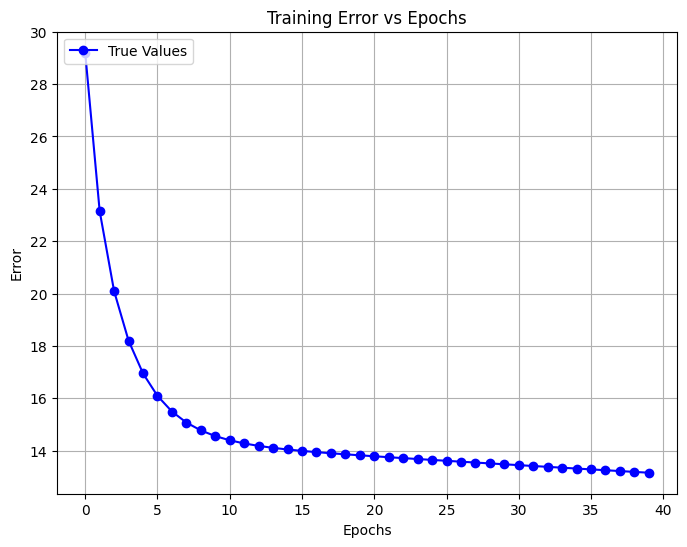




Mean Squared Error of Test Set: 0.007900550278686278
R2 Score of Test Set: 0.42781420476622156

Mean Squared Error of Train Set: 0.007874532852679852
R2 Score of Train Set: 0.39968401813456744


In [7]:
class ANN:
  def __init__(self):
    # fetch dataset
    abalone = fetch_ucirepo(id=1)

    #Loading the data
    self.train = abalone.data.features
    self.test = abalone.data.targets

    # metadata
    print(abalone.metadata)

    # variable information
    print(abalone.variables)
    print('-'*70)

  def Preprocessing(self):
    #Preprocessing of data
    print("\033[1mPreprocessing\n\033[0m")
    #one hot encoding of the categorical variable "sex" of abalone dataset
    encoded=pd.get_dummies(self.train['Sex'],prefix='Sex')
    self.train=pd.concat([encoded,self.train],axis=1)
    self.train=self.train.drop(['Sex'],axis=1)
    print(self.train)
    print(self.test)

    #calling the function for splitting the data into train and test
    self.split_data()

    #Applying min max scaling to the data
    numericals=['Length', 'Diameter','Height', 'Whole_weight', 'Shucked_weight','Viscera_weight', 'Shell_weight']
    scaler = MinMaxScaler()
    scaled=scaler.fit_transform(
        pd.concat([self.X_train.drop(columns=['Sex_F','Sex_I', 'Sex_M'],axis=1),
                   self.y_train
                   ],axis=1))
    self.X_train[numericals]=scaled[:,0:7]
    self.y_train=scaled[:,[7]]
    test_scaled=scaler.transform(pd.concat([self.X_test.drop(['Sex_F','Sex_I', 'Sex_M'],axis=1),self.y_test],axis=1))
    self.X_test[numericals]=test_scaled[:,0:7]
    self.y_test=test_scaled[:,[7]]


  def split_data(self):
    #Splitting the data into 80:20 ratio
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.train, self.test, test_size=0.2, random_state=42)
    self.train_size=self.X_train.shape[0]
    self.test_size=self.y_train.shape[0]

    #Printing samples of data
    print("\033[1mFeatures\n\033[0m")
    print(self.X_train.head(5))
    print('-'*70)
    print("\033[1mTarget varaible\n\033[0m")
    print(self.y_train.head(5))
    print('-'*70)

  def optimization(self,epochs, Activation, learning_rate, batch_size):
    #intializing the weights to random values
    W1=np.random.random((5, 10))
    W2=np.random.random((1,5))
    #intializing the biases to zeros
    Bias_1=np.zeros((1,5))
    Bias_2=np.zeros((1, 1))
    #variable for storing the training error per epoch
    Errors_per_epoch=[]

    #for loop for running the entire dataset multiple times
    for i in range(epochs):
      #For loop for running each batch separetely
      for j in range(0, self.train_size, batch_size):

        #Taking the input instances and their respective true values
        Attributes=np.array(self.X_train[j:j+batch_size])
        labels=np.array(self.y_train[j:j+batch_size])
        #Running the forward pass
        output=self.Forward_pass(W1,W2,Attributes,Activation, Bias_1, Bias_2)
        Output_Layer=output[2]
        Hidden_Layer=output[1]
        Intial_Layer=output[0]

        #calculating the delta values for output and hidden layer units
        delta_output=(self.derivative(Output_Layer,Activation))*(labels-Output_Layer)
        delta_hidden=(delta_output@W2)*self.derivative(Hidden_Layer, Activation)

        #updating the weights according to delta values
        W2 +=(learning_rate*(Hidden_Layer.T@delta_output)).T
        W1 +=(learning_rate*(Intial_Layer@delta_hidden)).T

        #Updating the biases for output and hidden layer units
        Bias_2+=np.sum(delta_output,axis=0, keepdims=True)*learning_rate
        Bias_1+=np.sum(delta_hidden,axis=0, keepdims=True)*learning_rate

      #Storing the squared error values for plotting the error
      output_1=self.Forward_pass(W1,W2,self.X_train,Activation,Bias_1,Bias_2)[2]
      Errors_per_epoch.append(self.Error(output_1,self.y_train))

    #PLot of graph of Training Error with respect to Epochs
    Error_sequence= range(len(Errors_per_epoch))

    plt.figure(figsize=(8, 6))
    plt.plot(Error_sequence, Errors_per_epoch, 'b-', marker='o', label='True Values')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend(loc='upper left')
    plt.title('Training Error vs Epochs')
    plt.grid(True)
    plt.show()

    #Evaluation of model
    self.evaulation(W1, W2, Activation, Bias_1, Bias_2)


  #Function for forward passing of input values with using parameters like weights, biases and activation function
  def Forward_pass( self, W1, W2, X, Activation, Bias_1, Bias_2):
    Input_Layer=np.transpose(X)
    Layer_1=W1@Input_Layer+ np.transpose(Bias_1)
    #Hidden layer output
    Layer_1=self.activation_function(Layer_1, Activation)
    Layer_2=W2@Layer_1+ Bias_2.T
    #Ouput layer
    Layer_2=self.activation_function(Layer_2, Activation)
    #returning outputs of all layers for backpropagation
    return [Input_Layer, Layer_1.T, Layer_2.T]

  #Activation Function that takes the value and return the computed activation function value
  def activation_function(self,x,Activation='Relu'):
    if Activation=='Relu':
      return np.maximum(0,x)

    elif Activation=='Sigmoid':
      return 1/(1+np.exp(-x))

    elif Activation=='Tanh':
      return np.tanh(x)

  #Derivatives of activation functions like Relu, Siqmoid, Tanh
  #Function uses the Activation varaible to return the respective value
  def derivative(self,x,Activation):
    #Relu Derivative
    if Activation=='Relu':
      return np.where(x > 0, 1, 0)
    #Sigmoid derivative
    elif Activation=='Sigmoid':
      return x*(1-x)
    #Tanh Derivative
    elif Activation=='Tanh':
      return 1-x*x

  #Squared error function for backpropagation
  def Error(self,X,y):
    return np.sum((X-y)*(X-y),axis=0)/2

  #Evaulation of the optimized model using test set and metrics like Mean Squared error, R2 score
  def evaulation(self, W1, W2, Activation, Bias_1, Bias_2):
    #Predicting the test values
    predictions=self.Forward_pass(W1,W2,self.X_test, Activation, Bias_1, Bias_2)[2]

    #Evaulating the test set predictions
    test_error=mean_squared_error(self.y_test,predictions)
    print("\n\n\nMean Squared Error of Test Set: "+ str(test_error))
    test_error=r2_score(self.y_test,predictions)
    print("R2 Score of Test Set: "+ str(test_error))

    #Predicting the Train Values
    predictions=self.Forward_pass(W1,W2,self.X_train, Activation, Bias_1, Bias_2)[2]

    #Evaulating the Train set predictions
    train_error=mean_squared_error(self.y_train, predictions)
    print("\nMean Squared Error of Train Set: "+ str(train_error))
    train_error=r2_score(self.y_train,predictions)
    print("R2 Score of Train Set: "+ str(train_error))



#Creation of Artificial Neural Network Model
model=ANN()
#Preprocessing the Dataset and splitting it to train and test
model.Preprocessing()

#Creation of model, optimizing on training data and evaluation based on below parameters
model.optimization(epochs = 40, Activation = 'Relu', learning_rate = 0.001, batch_size = 50)